In [1]:
import torch
from torch import nn
from torch import optim,no_grad
from torch.utils.data import DataLoader
from torchvision import models,transforms,datasets
from torch.nn import Dropout,ReLU,Linear,Sequential,LogSoftmax,Softmax
import pickle
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
#load and transform data from image directories

train_dataset=datasets.ImageFolder('train/',transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
))

print(train_dataset,end="\n\n")

val_dataset=datasets.ImageFolder('validate/',transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
))

print(val_dataset,end="\n\n")

test_dataset=datasets.ImageFolder('test/',transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
))

print(test_dataset,end="\n\n")

Dataset ImageFolder
    Number of datapoints: 18398
    Root Location: train/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

Dataset ImageFolder
    Number of datapoints: 2002
    Root Location: validate/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

Dataset ImageFolder
    Number of datapoints: 4600
    Root Location: test/
    Transforms (if any): C

In [3]:
idx2lbl={0:'Cat',1:'Dog'}

In [4]:
train_dataLoader=DataLoader(train_dataset,batch_size=128,shuffle=True)
test_dataLoader=DataLoader(test_dataset,batch_size=128,shuffle=True)
val_dataLoader=DataLoader(val_dataset,batch_size=128,shuffle=True)

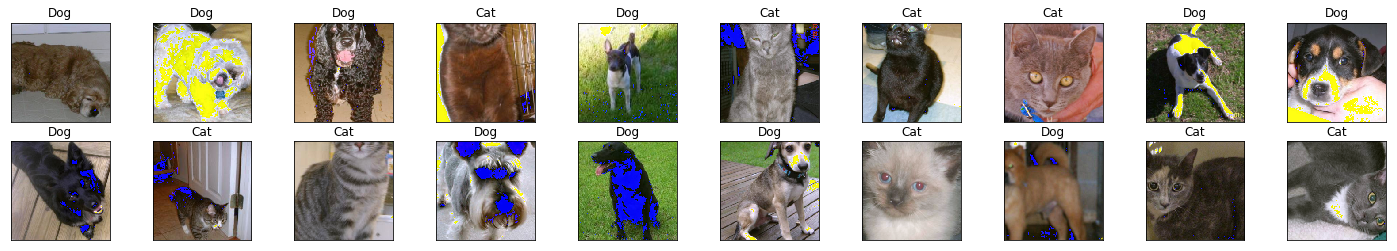

In [5]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

images,labels=next(iter(train_dataLoader))
fig=plt.figure(figsize=(25,4))

for i in range(1,21):
    ax=fig.add_subplot(2,10,i,xticks=[],yticks=[])
    ax.imshow(transforms.ToPILImage()(inv_normalize(images[i])))
    ax.set_title(str(idx2lbl[labels[i].item()]))

In [6]:
#load pretrained resnet50 model
model=models.resnet50(pretrained=True)

In [7]:
#set requires_grad to False inorder to freeze parameter update
for param in model.parameters():
    param.requires_grad=False

In [9]:
#resnet classification layer which need to be replaced with custom classification layer 
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [10]:
#create custom classifcation layer
classifier=Sequential(
    Dropout(p=0.5),
    Linear(in_features=2048, out_features=1024, bias=True),
    ReLU(),
    Dropout(p=0.3),
    Linear(in_features=1024, out_features=256, bias=True),
    ReLU(),
    Linear(in_features=256, out_features=2, bias=True),
    LogSoftmax(dim=1)
)

In [11]:
#replacing resnet classifier layer with custom one
model.fc=classifier

In [12]:
criterion=nn.NLLLoss()

In [13]:
optimizer=optim.Adam(model.fc.parameters(),lr=0.003)

In [14]:
model.to("cuda")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [15]:
def evaluate(model,dataLoader):
    
    predicted_labels_list=list()
    actual_labels_list=list()
    
    with no_grad(): #turning off gradient calculation
        model.eval() #setting model to evaluation mode,i.e,all dropout will be deactivated
        
        test_loss_acm=0
        accuracy_acm=0

        for images,labels in dataLoader:
            images,labels=images.cuda(),labels.cuda()
            output=model.forward(images)
            test_loss=criterion(output,labels)
            result=nn.functional.softmax(output,dim=1)
            test_loss_acm+=test_loss.item()
            result_labels=torch.argmax(result,dim=1)
            bools=(result_labels==labels)
            accuracy=bools.sum().type(torch.float)/len(bools)
            accuracy_acm+=accuracy
            
            predicted_labels_list.extend([x.item() for x in result_labels])
            actual_labels_list.extend([x.item() for x in labels])
            
        #setting model back to train mode
        model.train()

        avg_test_loss=test_loss_acm/len(dataLoader)
        avg_test_acc=accuracy_acm/len(dataLoader)
        
    return (avg_test_loss,avg_test_acc,predicted_labels_list,actual_labels_list)     

In [16]:
epochs=5

train_loss_pe=list()
val_loss_pe=list()

train_acc_pe=list()
val_acc_pe=list()

for epoch in range(1,epochs+1):
    running_loss=0
    running_acc=0
    
    for images,labels in tqdm(train_dataLoader):
        images=images.to("cuda")
        labels=labels.to("cuda")
        
        #set optimizer grad to zero
        optimizer.zero_grad()
        
        #forward pass
        output=model.forward(images)
        
        #loss
        loss=criterion(output,labels)
        
        #train accuracy
        result=torch.argmax(output,dim=1)
        running_loss+=loss.item()
        running_acc+=torch.mean((result==labels).type(torch.float))
        
        #backprop
        loss.backward()
        
        #descent
        optimizer.step()
    else:
        train_loss=running_loss/len(train_dataLoader)
        train_acc=running_acc/len(train_dataLoader)
        
        val_loss,val_acc,pred,actual=evaluate(model,val_dataLoader)
        
        train_loss_pe.append(train_loss)
        val_loss_pe.append(val_loss)
        
        train_acc_pe.append(train_acc.item())
        val_acc_pe.append(val_acc.item())
        
        print("EPOCH: {}".format(epoch))
        print("Train Loss: {:.3f}".format(train_loss,end=" "))
        print("Val Loss: {:.3f}".format(val_loss,end=" "))
        print("Train Accuracy: {:.2f}%".format(train_acc*100,end=" "))
        print("Val Accuracy: {:.2f}%".format(val_acc*100,end=" "))
        
        with open("Models/resnet50_tl_{}.pth".format(epoch),"wb") as f:
            model.eval()
            pickle.dump(model,f)
            model.train()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:05<00:00,  1.56s/it]


EPOCH: 1
Train Loss: 0.215
Val Loss: 0.042
Train Accuracy: 92.95%
Val Accuracy: 98.57%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:08<00:00,  1.58s/it]


EPOCH: 2
Train Loss: 0.068
Val Loss: 0.045
Train Accuracy: 97.42%
Val Accuracy: 98.09%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:04<00:00,  1.57s/it]


EPOCH: 3
Train Loss: 0.069
Val Loss: 0.062
Train Accuracy: 97.36%
Val Accuracy: 97.53%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:03<00:00,  1.57s/it]


EPOCH: 4
Train Loss: 0.070
Val Loss: 0.039
Train Accuracy: 97.32%
Val Accuracy: 98.58%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:07<00:00,  1.57s/it]


EPOCH: 5
Train Loss: 0.067
Val Loss: 0.042
Train Accuracy: 97.38%
Val Accuracy: 98.56%


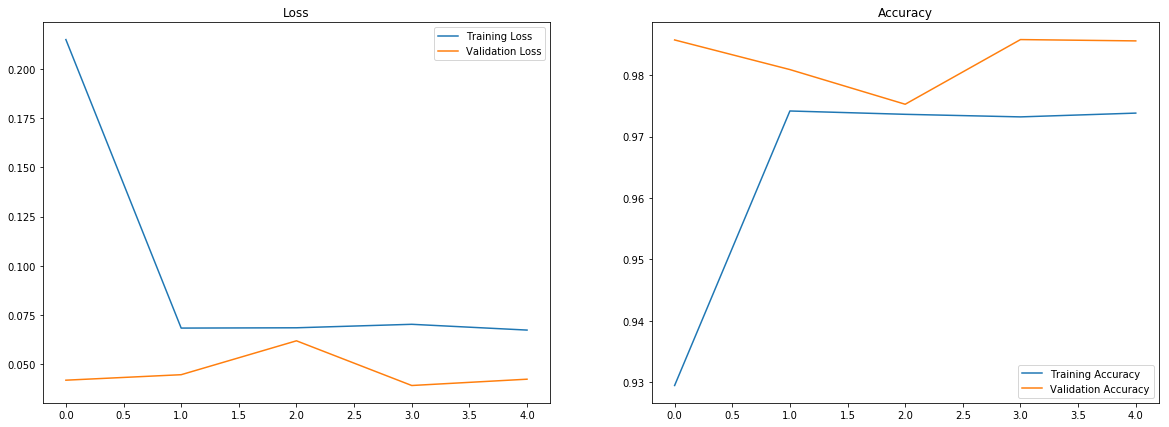

In [17]:
plots=[(train_loss_pe,val_loss_pe),(train_acc_pe,val_acc_pe)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

In [18]:
#selecting the best model
with open("Models/resnet50_tl_5.pth","rb") as f:
    loaded_model=pickle.load(f)

In [19]:
avg_test_loss,avg_test_acc,predicted_label,actual_label=evaluate(loaded_model,test_dataLoader)
print("Test Loss:{:.3f}".format(avg_test_loss,end="  "))
print("Test Accuracy:{:.2f}%".format(avg_test_acc*100,end=" "))

Test Loss:0.047
Test Accuracy:98.28%


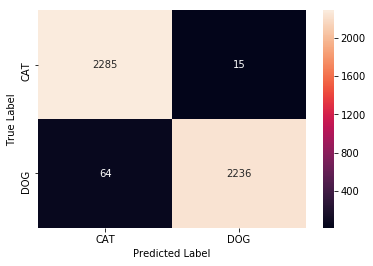

In [20]:
cnfn_mat=confusion_matrix(actual_label,predicted_label)
sns.heatmap(cnfn_mat,annot=cnfn_mat,fmt='',xticklabels=['CAT','DOG'],yticklabels=['CAT','DOG'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
report=pd.DataFrame.from_dict(classification_report(actual_label,predicted_label,output_dict=True)).T

In [22]:
report['Label']=[idx2lbl.get(int(x)) if x.isdigit() else " " for x in report.index]

In [23]:
report=report[['Label','f1-score','precision','recall','support']]

In [24]:
report

,Label,f1-score,precision,recall,support
0,Cat,0.983007,0.972754,0.993478,2300.0
1,Dog,0.982641,0.993336,0.972174,2300.0
micro avg,,0.982826,0.982826,0.982826,4600.0
macro avg,,0.982824,0.983045,0.982826,4600.0
weighted avg,,0.982824,0.983045,0.982826,4600.0
